In [ ]:
#https://rpubs.com/mharris/multiclass_xgboost

In [1]:
install.packages("disk.frame", repo="https://cran.rstudio.com/")
install.packages("xgboost")
install.packages("Ckmeans.1d.dp")
library(tidyverse)
library(xgboost)  # the main algorithm
#library(archdata) # for the sample dataset
library(caret)    # for the confusionmatrix() function (also needs e1071 package)
library(dplyr)    # for some data preperation
library(Ckmeans.1d.dp) # for xgb.ggplot.importance
library(caret)
library(nnet)
library(reticulate)
sagemaker <- import('sagemaker')
session <- sagemaker$Session()
bucket <- session$default_bucket()

also installing the dependencies ‘pryr’, ‘fst’

Warning message in install.packages("disk.frame", repo = "https://cran.rstudio.com/"):
“installation of package ‘pryr’ had non-zero exit status”Warning message in install.packages("disk.frame", repo = "https://cran.rstudio.com/"):
“installation of package ‘fst’ had non-zero exit status”Warning message in install.packages("disk.frame", repo = "https://cran.rstudio.com/"):
“installation of package ‘disk.frame’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ────────────────────────

In [2]:
# Load the data
set.seed(717)
triagedata <- get(load(file = "processedData5.RData"))
#head(data)
#data <- as.dataframe(data)
#sapply(data, class)
str(triagedata)
summary(triagedata)
dim(triagedata)

tibble [556,298 × 107] (S3: tbl_df/tbl/data.frame)
 $ PRESENTING_PROBLEM                      : Factor w/ 220 levels "Abdominal distension",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ PATIENT_ID                              : Factor w/ 368472 levels "0000196c5c11094e3014b171ea3e1846d3dcd8ef",..: 307925 201284 169928 296938 66423 219078 293523 20566 317304 293359 ...
 $ AGE                                     : num [1:556298] 50 49 55 62 50 75 46 69 70 86 ...
 $ ADMISSION_WITHIN_48_HOURS               : num [1:556298] 0 0 0 0 0 0 0 0 0 0 ...
 $ TRIAGE_DT_TM                            : POSIXct[1:556298], format: "2019-08-04 02:50:00" "2018-01-05 00:52:00" ...
 $ TRIAGE_CATEGORY                         : Factor w/ 5 levels "1","2","3","4",..: 3 3 2 3 3 3 3 2 4 3 ...
 $ TRIAGE_PRESENTING_INFORMATION           : chr [1:556298] "abvdo distension for last 3 days. no vomting pt has peg tube insitu. has traumatic brain injury was due to go t"| __truncated__ "GP referal with low Hb. Saw GP as was feeling le

                         PRESENTING_PROBLEM
 Pain, abdominal                  : 58690  
 Pain, chest                      : 48055  
 Unwell                           : 26951  
 Respiratory - shortness of breath: 25140  
 Care - patient review            : 22087  
 (Other)                          :372531  
 NA's                             :  2844  
                                    PATIENT_ID          AGE        
 be763e67f4a28e30f71cdbadaea4813bd28cdda8:   234   Min.   :  0.00  
 a40ac0bb8fb629b54d4d87678a65f8243d169405:   184   1st Qu.: 24.00  
 40afc5643936dfe8f32373af04360fce28ecaa24:   157   Median : 39.00  
 34591ed9ac883d57997d3b19563dac8956909b0e:   138   Mean   : 41.94  
 d4ef8dd7aa81f5f363335eb227f892bc7cd3094a:   129   3rd Qu.: 61.00  
 961cc31088f2a6d5b51efd07d594a4089b62b7ad:   124   Max.   :107.00  
 (Other)                                 :555332                   
 ADMISSION_WITHIN_48_HOURS  TRIAGE_DT_TM                 TRIAGE_CATEGORY
 Min.   :0.00000           Min.

[1] 556298    107

In [3]:
library(dplyr)
#ED_data = select(data,-ID)
triagedata$ID <- NULL
ED_data = triagedata %>% 
  #select(-ends_with('_2')) %>%
  select(-ends_with('1_DT_TM')) %>%
  select(-ends_with('2_DT_TM')) %>%
  select(-c(AGE, PRESENTING_PROBLEM, PATIENT_ID,TRIAGE_DT_TM)) %>%
  select(-c(TRIAGE_PRESENTING_INFORMATION,TRIAGE_PRESENTING_ADDITIONAL_INFORMATION,PATIENT_PROBLEM_HISTORY)) %>%
  select(TRIAGE_CATEGORY, everything()) 
ED_data$TRIAGE_CATEGORY = as.numeric(ED_data$TRIAGE_CATEGORY)
str(ED_data)
summary(ED_data)

tibble [556,298 × 75] (S3: tbl_df/tbl/data.frame)
 $ TRIAGE_CATEGORY             : num [1:556298] 3 3 2 3 3 3 3 2 4 3 ...
 $ ADMISSION_WITHIN_48_HOURS   : num [1:556298] 0 0 0 0 0 0 0 0 0 0 ...
 $ AVPU_1                      : num [1:556298] 1 1.04 1.04 1 1 ...
 $ AVPU_2                      : num [1:556298] 1 0 0 1 1 1 1 1 1 1 ...
 $ GCS_1                       : num [1:556298] 14.9 14.9 14.9 15 14.9 ...
 $ GCS_2                       : num [1:556298] 0 0 0 15 0 0 0 14 15 15 ...
 $ RR_1                        : num [1:556298] 18 18.8 24 20 18 ...
 $ RR_2                        : num [1:556298] 18 0 0 18 18 18 15 34 20 19 ...
 $ O2SATS_1                    : num [1:556298] 100 98.1 91 93 99 ...
 $ O2SATS_2                    : num [1:556298] 100 0 0 93 99 97 97 96 99 100 ...
 $ FIO2_1                      : num [1:556298] 35.8 43 39.6 710.4 39.6 ...
 $ FIO2_2                      : num [1:556298] 0 0 0 0 0 0 0 22 0 0 ...
 $ PULSE_1                     : num [1:556298] 97 86.4 108 85 75

 TRIAGE_CATEGORY ADMISSION_WITHIN_48_HOURS     AVPU_1          AVPU_2      
 Min.   :1.000   Min.   :0.00000           Min.   :1.000   Min.   :0.0000  
 1st Qu.:2.000   1st Qu.:0.00000           1st Qu.:1.000   1st Qu.:0.0000  
 Median :3.000   Median :0.00000           Median :1.000   Median :0.0000  
 Mean   :3.156   Mean   :0.06311           Mean   :1.034   Mean   :0.4084  
 3rd Qu.:4.000   3rd Qu.:0.00000           3rd Qu.:1.034   3rd Qu.:1.0000  
 Max.   :5.000   Max.   :1.00000           Max.   :5.000   Max.   :5.0000  
     GCS_1           GCS_2             RR_1             RR_2       
 Min.   : 3.00   Min.   : 0.000   Min.   :  0.00   Min.   :  0.00  
 1st Qu.:14.87   1st Qu.: 0.000   1st Qu.: 18.00   1st Qu.:  0.00  
 Median :14.94   Median : 0.000   Median : 18.82   Median : 16.00  
 Mean   :14.86   Mean   : 2.765   Mean   : 20.62   Mean   : 10.73  
 3rd Qu.:15.00   3rd Qu.: 0.000   3rd Qu.: 20.00   3rd Qu.: 18.00  
 Max.   :15.00   Max.   :15.000   Max.   :249.00   Max.   :1

In [4]:
ED_data <- as.data.frame(ED_data)
str(ED_data)

'data.frame':	556298 obs. of  75 variables:
 $ TRIAGE_CATEGORY             : num  3 3 2 3 3 3 3 2 4 3 ...
 $ ADMISSION_WITHIN_48_HOURS   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ AVPU_1                      : num  1 1.04 1.04 1 1 ...
 $ AVPU_2                      : num  1 0 0 1 1 1 1 1 1 1 ...
 $ GCS_1                       : num  14.9 14.9 14.9 15 14.9 ...
 $ GCS_2                       : num  0 0 0 15 0 0 0 14 15 15 ...
 $ RR_1                        : num  18 18.8 24 20 18 ...
 $ RR_2                        : num  18 0 0 18 18 18 15 34 20 19 ...
 $ O2SATS_1                    : num  100 98.1 91 93 99 ...
 $ O2SATS_2                    : num  100 0 0 93 99 97 97 96 99 100 ...
 $ FIO2_1                      : num  35.8 43 39.6 710.4 39.6 ...
 $ FIO2_2                      : num  0 0 0 0 0 0 0 22 0 0 ...
 $ PULSE_1                     : num  97 86.4 108 85 75 ...
 $ PULSE_2                     : num  98 0 0 84 78 66 99 97 75 75 ...
 $ HEART_RATE_1                : num  81.8 81.7 80.8 81.1 80.

In [5]:
# Convert the Species factor to an integer class starting at 0
# This is picky, but it's a requirement for XGBoost
TRIAGE_CATEGORY = ED_data$TRIAGE_CATEGORY
data_label = as.numeric(ED_data$TRIAGE_CATEGORY)-1
ED_data$TRIAGE_CATEGORY = NULL

In [6]:
n = nrow(ED_data)
train_index = sample(n,floor(0.8*n))
train_data = as.matrix(ED_data[train_index,])
train_label = data_label[train_index]
test.data = as.matrix(ED_data[-train_index,])
test.label = data_label[-train_index]

In [7]:
# Make split index
#train_index <- sample(1:nrow(ED_data), nrow(ED_data)*0.8)
# Full data set
data_variables <- as.matrix(ED_data[,-1])
#data_label <- ED_data[,"TRIAGE_CATEGORY"]
data_matrix <- xgb.DMatrix(data = as.matrix(ED_data), label = data_label)
# split train data and make xgb.DMatrix
train_data   <- data_variables[train_index,]
train_label  <- data_label[train_index]
train_matrix <- xgb.DMatrix(data = train_data, label = train_label)
# split test data and make xgb.DMatrix
test_data  <- data_variables[-train_index,]
test_label <- data_label[-train_index]
test_matrix <- xgb.DMatrix(data = test_data, label = test_label)

In [8]:
numberOfClasses <- length(unique(TRIAGE_CATEGORY))
xgb_params <- list(objective = "multi:softprob",
                   eval_metric = "mlogloss",
                   num_class = numberOfClasses)
cv.nround <- 100 # number of XGBoost rounds
cv.nfold  <- 10

# Fit cv.nfold * cv.nround XGB models and save OOF predictions
cv_model <- xgb.cv(params = xgb_params,
                   data = train_matrix, 
                   nrounds = cv.nround,
                   nfold = cv.nfold,
                   verbose = 0,
                   prediction = TRUE)

In [9]:
OOF_prediction <- data.frame(cv_model$pred) %>%
  mutate(max_prob = max.col(., ties.method = "last"),
         label = train_label + 1)
head(OOF_prediction)

X1,X2,X3,X4,X5,max_prob,label
0.0001048430,0.02092255,0.1512528,0.5806858,0.247033998,4,5
0.0022460010,0.06293585,0.7358886,0.1970145,0.001915096,3,3
0.0003472645,0.11017692,0.6752098,0.2112791,0.002986944,3,3
0.0473262444,0.19032030,0.1375074,0.4037430,0.221103087,4,2
0.0079173511,0.08590624,0.4899345,0.3999053,0.016336650,3,3
0.0005034328,0.02641051,0.1735737,0.5489808,0.250531584,4,4


In [11]:
install.packages("e1071")
library(e1071)
confusionMatrix(factor(OOF_prediction$max_prob),
                factor(OOF_prediction$label),
                mode = "everything")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


Confusion Matrix and Statistics

          Reference
Prediction     1     2     3     4     5
         1  1293   612   134    34     6
         2  3751 80880 24551  6389   862
         3  1210 23447 92491 39830  2344
         4   454  9865 40325 80855 22008
         5    23   334  1508  3178  8654

Overall Statistics
                                         
               Accuracy : 0.5936         
                 95% CI : (0.5922, 0.595)
    No Information Rate : 0.3573         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.4203         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5
Sensitivity          0.192096   0.7025   0.5817   0.6206  0.25548
Specificity          0.998207   0.8922   0.7663   0.7692  0.98773
Pos Pred Value       0.621934   0.6946   0.5805   0.5267  0.63182
Neg Pred Value  

In [12]:
bst_model <- xgb.train(params = xgb_params,
                       data = train_matrix,
                       nrounds = cv.nround)

# Predict hold-out test set
test_pred <- predict(bst_model, newdata = test_matrix)
test_prediction <- matrix(test_pred, nrow = numberOfClasses,
                          ncol=length(test_pred)/numberOfClasses) %>%
  t() %>%
  data.frame() %>%
  mutate(label = test_label + 1,
         max_prob = max.col(., "last"))
# confusion matrix of test set
confusionMatrix(factor(test_prediction$max_prob),
                factor(test_prediction$label),
                mode = "everything")

Confusion Matrix and Statistics

          Reference
Prediction     1     2     3     4     5
         1   355   154    33     5     1
         2   982 20096  6064  1597   223
         3   282  6005 23397 10026   572
         4   109  2467  9975 20052  5625
         5    10    70   369   712  2079

Overall Statistics
                                          
               Accuracy : 0.593           
                 95% CI : (0.5901, 0.5959)
    No Information Rate : 0.3581          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4191          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5
Sensitivity          0.204258   0.6980   0.5873   0.6190  0.24459
Specificity          0.998238   0.8925   0.7636   0.7695  0.98870
Pos Pred Value       0.647810   0.6939   0.5808   0.5245  0.64167
Neg Pre

In [13]:
# get the feature real names
names <-  colnames(ED_data[,-1])
# compute feature importance matrix
importance_matrix = xgb.importance(feature_names = names, model = bst_model)
head(importance_matrix)

Feature,Gain,Cover,Frequency
Cardiovascular,0.20899043,0.02995439,0.009054402
AVPU_2,0.06577008,0.01256155,0.009584786
Administration,0.06073740,0.02162093,0.009660555
Gastrointestinal,0.05785812,0.01650089,0.007955751
PULSE_1,0.05130917,0.07506575,0.078117897
RR_1,0.05113612,0.05926253,0.059933323


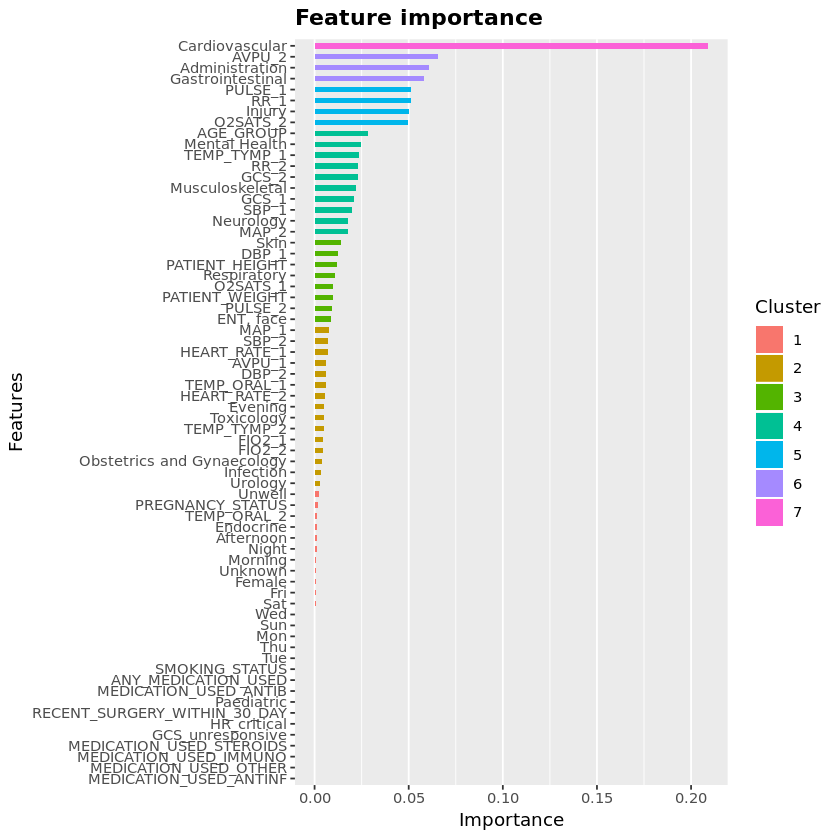

In [14]:
gp = xgb.ggplot.importance(importance_matrix)
print(gp)